In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import h5py
from io import BytesIO
from PIL import Image

from sklearn.model_selection import GroupKFold

In [2]:
SEED = 2022
FOLDS = 5
INPUT_PATH = Path("/kaggle/input/isic-2024-challenge/")
OUTPUT_FILENAME = "folds.csv"

In [3]:
id_column = "isic_id"
target_column = "target"
group_column = "patient_id"
fold_column = "fold"

AUSTRALIAN_ATTRIBUTIONS = [
    "ACEMID MIA",
    "Frazer Institute, The University of Queensland, Dermatology Research Centre"
]

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False);print(f"Train data size: {train_metadata.shape}")
train_images = h5py.File(INPUT_PATH / "train-image.hdf5", mode="r")
train_metadata.head()

Train data size: (401059, 55)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


ISIC_2346081: Label: 1


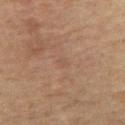

ISIC_0573025: Label: 0


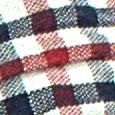

ISIC_1443812: Label: 0


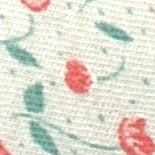

ISIC_5374420: Label: 0


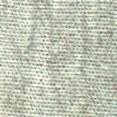

In [4]:
drop_ids = ["ISIC_2346081", "ISIC_0573025", "ISIC_1443812", "ISIC_5374420"]
# https://www.kaggle.com/competitions/isic-2024-challenge/discussion/528168#2960144
# https://www.kaggle.com/competitions/isic-2024-challenge/discussion/521145#2935689

for drop_id in drop_ids:
    img = Image.open(BytesIO(train_images[drop_id][()]))
    print(f"{drop_id}: Label: {train_metadata.loc[train_metadata[id_column] == drop_id, target_column].item()}")
    display(img)

In [5]:
folds = np.zeros(train_metadata.shape[0], dtype=int)

gkf = GroupKFold(n_splits=FOLDS)
for fold_idx, (_, val_idx) in enumerate(gkf.split(train_metadata, train_metadata[target_column], train_metadata[group_column])):
    folds[val_idx] = fold_idx + 1
train_metadata[fold_column] = folds
train_metadata.loc[train_metadata[id_column].isin(drop_ids), fold_column] = -1
train_metadata["is_aus"] = np.where(train_metadata["attribution"].isin(AUSTRALIAN_ATTRIBUTIONS), 1, 0)

for fold in np.unique(train_metadata["fold"]):
    if fold < 0:
        continue
    print(f"Fold: {fold}")
    print(f"Target mean: {train_metadata.loc[train_metadata[fold_column] == fold, target_column].mean()}")
    print(f"Unique patients: {train_metadata.loc[train_metadata[fold_column] == fold, group_column].nunique()}\n")

Fold: 1
Target mean: 0.0009599321814147156
Unique patients: 206

Fold: 2
Target mean: 0.000972435202154318
Unique patients: 209

Fold: 3
Target mean: 0.0009973694381069929
Unique patients: 208

Fold: 4
Target mean: 0.0009849268785298408
Unique patients: 209

Fold: 5
Target mean: 0.0009724473257698541
Unique patients: 210



In [6]:
columns_to_write = [id_column, group_column, fold_column, "is_aus"]
train_metadata[columns_to_write].head(n=10)

,isic_id,patient_id,fold,is_aus
0,ISIC_0015670,IP_1235828,4,0
1,ISIC_0015845,IP_8170065,1,0
2,ISIC_0015864,IP_6724798,5,0
3,ISIC_0015902,IP_4111386,2,1
4,ISIC_0024200,IP_8313778,1,0
5,ISIC_0035502,IP_3026693,5,0
6,ISIC_0051648,IP_0218255,1,1
7,ISIC_0051665,IP_7734648,2,0
8,ISIC_0051710,IP_1307115,2,0
9,ISIC_0051758,IP_2180091,5,0


In [7]:
train_metadata[columns_to_write].to_csv(OUTPUT_FILENAME, index=False)